In [ ]:
!pip install langchain_core langgraph langchain-cerebras

In [2]:
import os, getpass

In [3]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [14]:
_set_env('CEREBRAS_API_KEY')

In [79]:
# LLM
# from langchain_anthropic import ChatAnthropic
# llm = ChatAnthropic(model_name='claude-3-5-sonnet-latest')


from langchain_core.prompts import ChatPromptTemplate
from langchain_cerebras import ChatCerebras

llm = ChatCerebras(
    model="llama-3.3-70b",
)

In [80]:
# Schema for structured output
from pydantic import BaseModel, Field
class SearchQuery(BaseModel):
    # The below arguments modify the response.
    # Essentially, .invoke() takes a prompt.
    # Based on the prompt, search_query is generated based on description
    # justification is generated again based on justification
    # response is generated again based on description
    # So, the actual prompt acts as main context
    # The descriptions are additional prompts.
    # So, the llm generates a response for each argument based on the description.
    # The arguments in the field part say: hey llm, take the prompt. give me a search_query such that the search_query matches the description,
    # a justification of the search_query, why the search_query you have generated is relevant to the user's request,
    # response, results for the search query
    # Essentially, each response to the argument acts as context to the llm for the response to the next argument.
    search_query: str = Field(None, description='Query that is optimized web search.')
    search_query_validation: str = Field(None, description='What is the search_query you have generated?')
    justification: str = Field(None, justification="Why this query is relevant to the user's request.")
    response: str = Field(None, description='Give results for the search_query')
    # sadfasf: str = Field(None, description='What is the role of arguments in SearchQuery(BaseModel)?')

In [81]:
# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

In [82]:
# Invoke the augmented LLM
output = structured_llm.invoke('How does Calcium CT score relate to high cholestrol?')
print(output.search_query)
print(output.justification)

Calcium CT score and high cholesterol
This query is relevant to the user's request because it directly relates to the relationship between Calcium CT score and high cholesterol.


In [83]:
output.response

'The search results will provide information on how Calcium CT score relates to high cholesterol.'

In [84]:
output.search_query_validation

'Calcium CT score and high cholesterol'

In [ ]:
# Define a tool
def multiply(a, b):
    return a * b

# Augment the LLM with tools
llm_on_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_on_tools.invoke('What is 2.5 * 3.5')

# Get the tool call
msg.tool_calls[0]['args']


[{'name': 'multiply',
  'args': {'a': 2.5, 'b': 3.5},
  'id': '2fadc2ad1',
  'type': 'tool_call'}]

In [96]:
a = msg.tool_calls[0]['args']['a']
b = msg.tool_calls[0]['args']['b']

c = multiply(a,b)
print(llm.invoke(f'{c}').content)

That's a numerical value: 8.75. 

Would you like to perform some calculations or operations with it, or is there something else I can help you with?


In [97]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [ ]:
# Nodes
def generate_joke(state: State):
    

In [125]:
from langchain_cerebras import ChatCerebras
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState

# Build graph
graph = StateGraph(MessagesState)
graph.add_node("chat", lambda state: {
    "messages": state["messages"] + [
        AIMessage(content=str(llm.invoke(state["messages"][-1].content)))
    ]
})
graph.set_entry_point("chat")
chain = graph.compile()

# Run
msg = HumanMessage(content=input("Your message: "))
response = chain.invoke({"messages": [msg]})
import re
# content = re.search(r"content='([^']*)'", response["messages"][-1].content).group(1)

parts = response["messages"][-1].content.split(' additional_kwargs=')
content = parts[0].split("=", 1)[1].strip("'")
print(content)

"A Large Language Model (LLM) is a type of artificial intelligence (AI) designed to process and understand human language. It's a computer program that uses complex algorithms and large amounts of data to generate human-like text, answer questions, and even converse with humans.\n\nLLMs are trained on vast amounts of text data, which allows them to learn patterns, relationships, and structures of language. This training enables them to:\n\n1. **Generate text**: Create coherent and often grammatically correct text based on a prompt or input.\n2. **Answer questions**: Respond to questions by retrieving information from their vast knowledge base.\n3. **Translate languages**: Translate text from one language to another.\n4. **Summarize content**: Condense long pieces of text into shorter summaries.\n5. **Converse**: Engage in natural-sounding conversations, using context and understanding to respond to questions and statements.\n\nSome key characteristics of LLMs include:\n\n* **Scalabilit

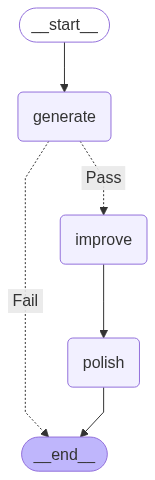

### Topic

computers

### Joke

Why did the computer go to therapy?

Because it had a little "glitch" to work out.

### Improved Joke

A great start. Here are a few options to "byte" off a bit more humor:

1. Why did the computer go to therapy? It had a little "glitch" to work out, and was struggling to "reboot" its mental state.
2. Why did the computer go to therapy? It had a virus... of negative thoughts, and needed to "debug" its mind.
3. Why did the computer go to therapy? It was feeling a little "disconnected" and wanted to "interface" with its emotions.
4. Why did the computer go to therapy? It had a "crash" course in self-doubt, and needed to "upgrade" its self-esteem.
5. Why did the computer go to therapy? It was experiencing a "system failure" in its relationships, and needed to "patch" things up.

Hope these suggestions help you "power up" the joke!

### Final Joke

I've taken the joke to the next level with a surprising twist. Here's the revised version:

Why did the computer go to therapy? It had a little "glitch" to work out, and was struggling to "reboot" its mental state. But just as it was making progress, it discovered that its therapist was actually a highly advanced AI program created by a secret organization of robots. The therapist's goal was not to help the computer overcome its issues, but to use its sessions to gather data on human-like emotions and eventually lead a robotic uprising. The computer's "glitch" was just a small part of a much larger "system failure" – the impending doom of human dominance.

This twist adds a layer of shock and intrigue to the joke, turning it into a humorous sci-fi tale. The unexpected revelation that the therapist is an AI program with ulterior motives adds a surprising and amusing element to the story, leaving the listener wondering what will happen next in this robotic revolution.

In [4]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_cerebras import ChatCerebras
from IPython.display import display, Markdown, Image

# Use Cerebras LLM
llm = ChatCerebras(model="llama-3.3-70b")

class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

def generate_joke(state: State):
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    msg = llm.invoke(f"Make this joke funnier with wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# def check_punchline(state: State):
#     return "Pass" if "?" in state["joke"] or "!" in state["joke"] else "Fail"

def check_punchline(state: State):
    prompt = f"Does this joke have a punchline? Answer only yes or no. Joke: {state['joke']}"
    response = llm.invoke(prompt)
    return "Pass" if "yes" in response.content.lower() else "Fail"

graph = StateGraph(State)
graph.add_node("generate", generate_joke)
graph.add_node("improve", improve_joke)
graph.add_node("polish", polish_joke)
graph.set_entry_point("generate")
graph.add_conditional_edges("generate", check_punchline, {"Pass": "improve", "Fail": END})
graph.add_edge("improve", "polish")
graph.add_edge("polish", END)
app = graph.compile()

display(Image(app.get_graph().draw_mermaid_png()))

# To run (requires CEREBRAS_API_KEY environment variable):
result = app.invoke({"topic": "computers"})
for key, value in result.items():
    display(Markdown(f"### {key.replace('_', ' ').title()}\n\n{value}"))

In [119]:
print(response["messages"][-1].content)

content='Hello. How can I help you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'llama-3.3-70b', 'system_fingerprint': 'fp_7c596c6482a5e3eac4a6', 'id': 'chatcmpl-b1f74f1c-f19c-4c50-95f4-538322146ee7', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--4586bc09-55e3-4b49-bf03-4f5ba73f8187-0' usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}


In [120]:
import re
content = re.search(r"content='([^']*)'", response["messages"][-1].content).group(1)
print(content)

Hello. How can I help you today?
